In [1]:
import pandas as pd

In [2]:
file_path = 'weatherAUS.csv'
Aus_weather = pd.read_csv(file_path)

In [3]:
Aus_weather.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [4]:
# coastal_cities = ['Adelaide', 'Albany', 'Brisbane', 'Cairns', 'CoffsHarbour', 
#                   'Darwin', 'GoldCoast', 'Hobart', 'Melbourne', 'MelbourneAirport',
#                   'Newcastle', 'NorahHead', 'NorfolkIsland', 'Perth', 'PerthAirport',
#                   'Portland', 'Sydney', 'SydneyAirport', 'Townsville', 'Williamtown', 'Wollongong']
# Aus_weather = Aus_weather[Aus_weather['Location'].isin(coastal_cities)]

In [5]:
Aus_weather['Date'] = pd.to_datetime(Aus_weather['Date'])

In [6]:
def get_season(date):
    month = date.month
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

In [7]:
Aus_weather['Season'] = Aus_weather['Date'].apply(get_season)
df_spring = Aus_weather[Aus_weather['Season'] == 'Spring']
df_summer = Aus_weather[Aus_weather['Season'] == 'Summer']
df_autumn = Aus_weather[Aus_weather['Season'] == 'Autumn']
df_winter = Aus_weather[Aus_weather['Season'] == 'Winter']

In [8]:
len(df_spring), len(df_summer), len(df_autumn), len(df_winter)

(38264, 36737, 35337, 35122)

In [9]:
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

d:\Anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
def preprocess_weather_data(df):
    # Impute missing values for numerical columns
    num_cols = df.select_dtypes(include=[np.number]).columns
    imputer_num = SimpleImputer(strategy='median')
    df[num_cols] = imputer_num.fit_transform(df[num_cols])

    # Drop certain categorical columns
    df = df.drop(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'Date', 'Season'], axis=1)

    # Impute missing values for remaining categorical columns
    cat_cols = df.select_dtypes(include=['object']).columns
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

    # Encode categorical variables
    label_encoders = {}
    for column in cat_cols:
        label_encoder = LabelEncoder()
        df[column] = label_encoder.fit_transform(df[column].astype(str))
        label_encoders[column] = label_encoder

    return df, label_encoders
processed_weather_data, encoders = preprocess_weather_data(df_winter)

d:\Anaconda\envs\pytorch\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [11]:
processed_weather_data.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir',
       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [12]:
X = processed_weather_data.drop(['RainTomorrow'], axis=1)
y = processed_weather_data['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
pca = PCA(n_components=17)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [14]:
best_params = {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
logreg_pca = RandomForestClassifier(**best_params,random_state=42)
logreg_pca.fit(X_train_pca, y_train)
y_pred_pca = logreg_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
classification_rep_pca = classification_report(y_test, y_pred_pca)
print(classification_rep_pca)

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      8472
           1       0.72      0.42      0.54      2065

    accuracy                           0.86     10537
   macro avg       0.80      0.69      0.73     10537
weighted avg       0.84      0.86      0.84     10537



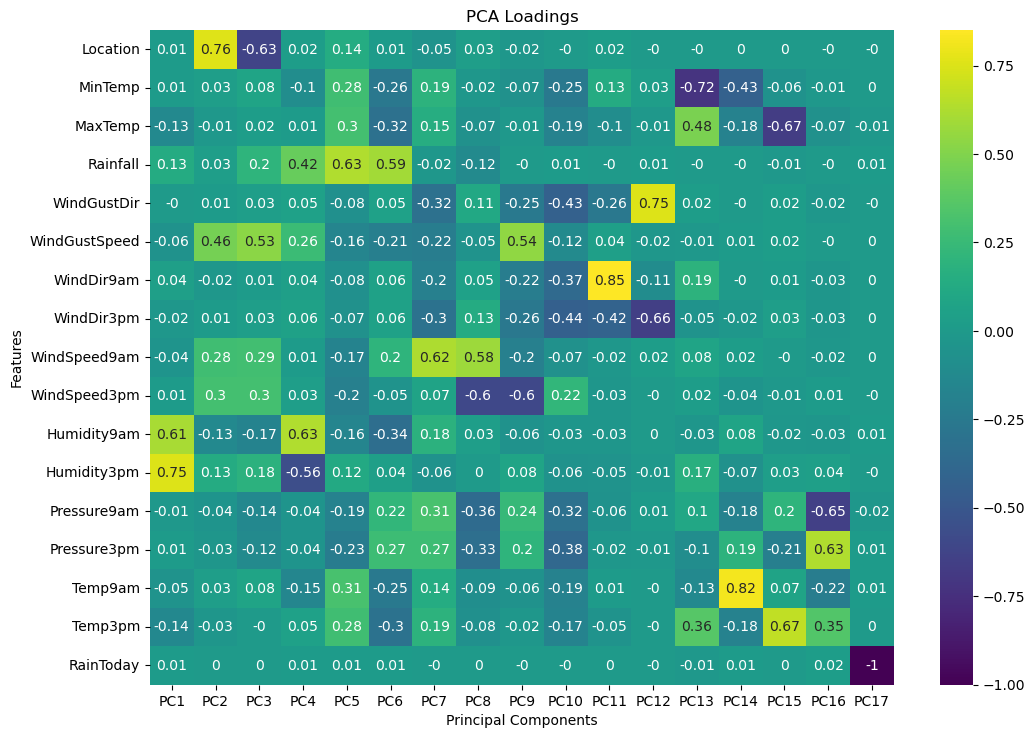

In [15]:
loadings = pca.components_
num_pc = pca.n_components_
pc_labels = ['PC'+str(i) for i in range(1, num_pc + 1)]
feature_labels = X.columns

# Create a DataFrame of loadings
df_loadings = pd.DataFrame(loadings.T, columns=pc_labels, index=feature_labels).round(2)

# Plotting the heatmap of loadings
plt.figure(figsize=(12, len(feature_labels)/2))
sns.heatmap(df_loadings, annot=True, cmap='viridis')
plt.title('PCA Loadings')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.show()

In [16]:
df_loadings = pd.DataFrame(loadings, columns=feature_labels)

# Identifying dominant features for each principal component
dominant_features = {}
for i in range(num_pc):
    pc = 'PC' + str(i + 1)
    # Sort the loadings by absolute value and get the feature with highest loading
    dominant_feature = df_loadings.iloc[i].abs().idxmax()
    dominant_features[pc] = dominant_feature

dominant_features

{'PC1': 'Humidity3pm',
 'PC2': 'Location',
 'PC3': 'Location',
 'PC4': 'Humidity9am',
 'PC5': 'Rainfall',
 'PC6': 'Rainfall',
 'PC7': 'WindSpeed9am',
 'PC8': 'WindSpeed3pm',
 'PC9': 'WindSpeed3pm',
 'PC10': 'WindDir3pm',
 'PC11': 'WindDir9am',
 'PC12': 'WindGustDir',
 'PC13': 'MinTemp',
 'PC14': 'Temp9am',
 'PC15': 'Temp3pm',
 'PC16': 'Pressure9am',
 'PC17': 'RainToday'}

In [17]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(X_train_pca.shape[1], 128)  # Adjusted input size
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x

In [18]:
X_train_tensor = torch.tensor(X_train_pca.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32))
X_test_tensor = torch.tensor(X_test_pca.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32))

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = NeuralNet()

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training loop
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()  # Adjusting the output shape
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluate the model
model.eval()
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs).squeeze()
        y_pred.extend(outputs.numpy())  # Collect raw outputs

# Convert predictions to binary (0 or 1) based on a 0.5 threshold
y_pred = np.array(y_pred)
y_pred_binary = (y_pred > 0.5).astype(int)

# Ensure y_test is a binary array
y_test_binary = y_test.values.astype(int)  # Assuming y_test is a pandas Series

# Compute classification report
classification_rep = classification_report(y_test_binary, y_pred_binary)

# Print the classification report
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.91      8472
           1       0.79      0.34      0.47      2065

    accuracy                           0.85     10537
   macro avg       0.82      0.66      0.69     10537
weighted avg       0.84      0.85      0.83     10537



In [19]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X_train_pca, y_train)

# Make predictions
y_pred = model.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


ModuleNotFoundError: No module named 'xgboost'